[*********************100%***********************]  10 of 10 completed


PC 1: Explained Variance = 0.3997, Cumulative = 0.3997
PC 2: Explained Variance = 0.1018, Cumulative = 0.5015
PC 3: Explained Variance = 0.0977, Cumulative = 0.5992
PC 4: Explained Variance = 0.0843, Cumulative = 0.6835
PC 5: Explained Variance = 0.0748, Cumulative = 0.7583
PC 6: Explained Variance = 0.0690, Cumulative = 0.8273
PC 7: Explained Variance = 0.0497, Cumulative = 0.8770
PC 8: Explained Variance = 0.0455, Cumulative = 0.9225
PC 9: Explained Variance = 0.0435, Cumulative = 0.9660
PC 10: Explained Variance = 0.0340, Cumulative = 1.0000


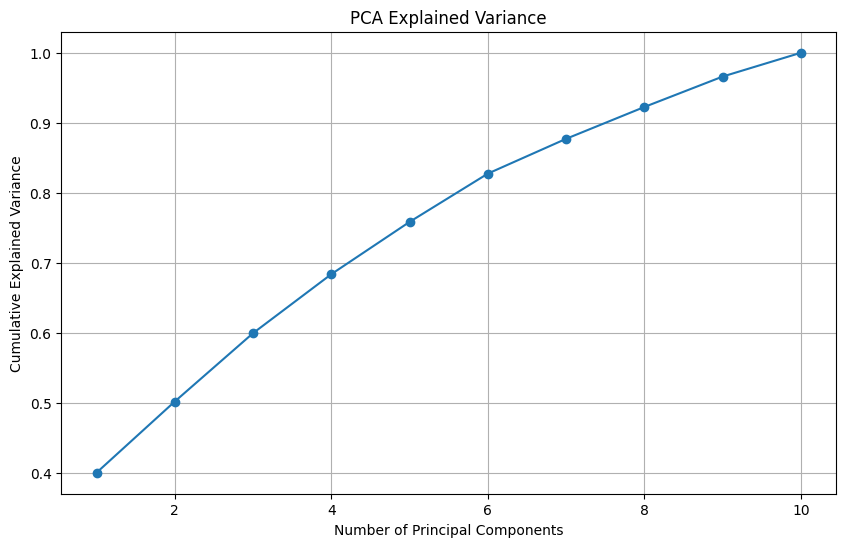


===== AAPL Regression Result =====
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1247.
Date:                Sat, 03 May 2025   Prob (F-statistic):          2.57e-139
Time:                        23:09:35   Log-Likelihood:                 514.28
No. Observations:                 173   AIC:                            -1013.
Df Residuals:                     165   BIC:                            -987.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [60]:

#EXERCISE 1: 
# Using this dataset and construct k factor portfolios by means of the principal components methodology. 
# How many factors would you include? Comment on the results. Use the estimated factors to test for the validity of the APT model in all known ways. 
# How would your results change if you excluded the Great Financial Crisis and the Covid crisis. i.e. using a shorter sample starting in 2010:01 and ending in 2020:02?


import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# List of ticker symbols
tickers = [
    "ABT",      # Abbott Laboratories
    "AXRX",     # AMexdrug
    "AAPL",     # Apple
    "BC",       # Brunswick Corp
    "GLW",      # Corning Inc.
    "EXC",      # Exelon
    "GD",       # General Dynamics
    "GE",       # General Electric
    "BK",       # Bank of New York Mellon
    "NSC"       # Norfolk Southern
]

#Download monthly data close prcfrom May 1, 2007 through Oct 31, 2021
df = yf.download(tickers, start="2007-05-01", end="2021-10-31", interval ="1mo", auto_adjust=False, actions=False )

#Extract just the 'Close' prices and drop any columns you don’t need
monthly_closes = df["Close"].dropna(how="all")  # drops rows where all tickers are NaN

#save to CSV
monthly_closes.to_csv("monthly_closes_for_1.csv")

#Calculate log returns
log_returns = np.log(monthly_closes / monthly_closes.shift(1)).dropna()

# Standardize the returns
scaler = StandardScaler()
returns_standardized = scaler.fit_transform(log_returns)

# Run PCA

pca = PCA()
pca.fit(returns_standardized)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Display the explained variance
for i, (ev, cv) in enumerate(zip(explained_variance_ratio, cumulative_variance), 1):
    print(f"PC {i}: Explained Variance = {ev:.4f}, Cumulative = {cv:.4f}")

# Plot cumulative variance to decide how many factors to keep
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

#Now get the PCA Factors or the scores

pca_scores = pd.DataFrame(pca.transform(returns_standardized), index=log_returns.index)

# Choose number of factors 
k = 7  # It is 0.87 at PC 7

factors = pca_scores.iloc[:, :k]
factors.columns = [f"Factor_{i+1}" for i in range(k)]

# Regress each stock's return on the k factors
alphas = []
p_values = []

for stock in log_returns.columns:
    y = log_returns[stock]
    X = sm.add_constant(factors)  # add intercept (alpha)
    model = sm.OLS(y, X).fit()
    
    alphas.append(model.params['const'])
    p_values.append(model.pvalues['const'])
    
    print(f"\n===== {stock} Regression Result =====")
    print(model.summary())

# Joint test for alphas = 0, this is for APT validity

alphas = np.array(alphas)
n = len(alphas)    # number of assets
T = len(log_returns)  # number of observations

# Calculate test statistic
test_stat = T * np.mean(alphas)**2 / np.var(alphas, ddof=1)

# Calculate p-value
p_val = 1 - stats.chi2.cdf(test_stat, df=1)

print("\n==========================")
print("Joint Test for Alpha = 0 (APT Validity)")
print(f"Test Statistic: {test_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject APT (Some alphas significantly different from 0)")
else:
    print("Do not reject APT (Alphas are jointly zero → APT holds)")


#How would my results change?????

print("\n\n====================")
print("APT TEST EXCLUDING Great Financial Crisis and COVID (2010-01 to 2020-02)")
print("====================\n")

# Filter the sample for 2010-01 to 2020-02
log_returns_filtered = log_returns.loc["2010-01-01":"2020-02-01"]

# Standardize again here
scaler_filtered = StandardScaler()
returns_standardized_filtered = scaler_filtered.fit_transform(log_returns_filtered)

# Run PCA again
pca_filtered = PCA()
pca_filtered.fit(returns_standardized_filtered)

explained_variance_ratio_filtered = pca_filtered.explained_variance_ratio_
cumulative_variance_filtered = explained_variance_ratio_filtered.cumsum()

# Print how many PCs to explain 85-90%
for i, (ev, cv) in enumerate(zip(explained_variance_ratio_filtered, cumulative_variance_filtered), 1):
    print(f"PC {i}: Explained Variance = {ev:.4f}, Cumulative = {cv:.4f}")

# Get PCA factors
pca_scores_filtered = pd.DataFrame(pca_filtered.transform(returns_standardized_filtered), index=log_returns_filtered.index)

# Choose number of factors (can use same k=7 or adjust based on output above)
k_filtered = 7
factors_filtered = pca_scores_filtered.iloc[:, :k_filtered]
factors_filtered.columns = [f"Factor_{i+1}" for i in range(k_filtered)]

# Regress again for the shorter sample
alphas_filtered = []

for stock in log_returns_filtered.columns:
    y = log_returns_filtered[stock]
    X = sm.add_constant(factors_filtered)
    model = sm.OLS(y, X).fit()
    
    alphas_filtered.append(model.params['const'])

# Joint test for alphas = 0
alphas_filtered = np.array(alphas_filtered)
n_filtered = len(alphas_filtered)
T_filtered = len(log_returns_filtered)

test_stat_filtered = T_filtered * np.mean(alphas_filtered)**2 / np.var(alphas_filtered, ddof=1)
p_val_filtered = 1 - stats.chi2.cdf(test_stat_filtered, df=1)

print("\n==========================")
print("Joint Test for Alpha = 0 (APT Validity for New Restricted Sample)")
print(f"Test Statistic: {test_stat_filtered:.4f}")
print(f"P-value: {p_val_filtered:.4f}")

if p_val_filtered < 0.05:
    print("Reject APT (Some alphas significantly different from 0)")
else:
    print("Do not reject APT (Alphas are jointly zero → APT holds)")


EXERCISE 1: 
Using the monthly returns of 10 stocks from May 2007 to October 2021, I performed Principal Component Analysis (PCA) to extract common factors and based on the cumulative explained variance, I selected 7 principal components which together explain approximately 88% of the total variance in returns.


To test the validity of the APT, I regressed each stock's returns on the 7 extracted PCA factors. According to APT, the should jointly be zero if the factors completely explain expected returns.

Full Sample (2007–2021):

Test statistic = 81.32, p-value = 0.0000 so... Reject APT
This result suggests that some stocks had non-zero alphas, meaning that the PCA factors do not fully capture all systematic influences or risk premiums in the data.

Restricted Sample (2010–2020):

Test statistic = 63.98, p-value = 0.0000 so...Reject APT again here.

Although the test statistic is somewhat lower, the rejection of APT persists. This suggests that the violation of APT in this case is not driven solely by extreme market conditions like the GFC or COVID crisis, but appears to be a more general feature of the data. THis tells me that the APT model with these factors does not fully explain expected returns in this dataset. The significant alphas indicate either omitted risk factors, market frictions, or behavioral elements inconsistent with the APT assumptions.

In [63]:
#EXERCISE 2:
# Create the impredictable components of the following series: 
# 1. the rate of change (delta log) of industrial production
#2. the default premium (BAA - AAA rates)
#3. the term premium (10 year - 3 month rate)
#4. inflation (year on year)
#Use a VAR with an appropriate number of lags. Use the resulting vari- ables as factors, together with the market portfolio returns to construct an APT model for assets returns contained in the file. Which factors turn to be relevant?
#How do results change taking into consideration the shorter subsample 2010:1 to 2019:12?

import pandas_datareader.data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from pandas_datareader.data import DataReader
import yfinance as yf
from scipy.stats import f

# Download the FRED series codes
series = {
    "AAA": "AAA",
    "BAA": "BAA",
    "INDPRO": "INDPRO",
    "CPI": "CPIAUCSL",
    "TB3MS": "TB3MS",
    "T10Y3MM": "T10Y3MM"
}

# Set start and end date
start = "2000-01-01"
end = "2021-12-31"

#Download the data
data = pd.DataFrame()
for name, code in series.items():
    data[name] = web.DataReader(code, "fred", start, end)

# Calculate required variables:
data['deltalog_indpro'] = np.log(data['INDPRO']) - np.log(data['INDPRO'].shift(1))
data['default_premium'] = data['BAA'] - data['AAA']
data['term_premium'] = data['T10Y3MM']
data['inflation'] = (data['CPI'] / data['CPI'].shift(12)) - 1

#KEep only the usable rows
factors = data[['deltalog_indpro', 'default_premium', 'term_premium', 'inflation']].dropna()

#Estimate VAR and get the unpredicted components
model = VAR(factors)
lag_order = model.select_order(maxlags=12)
selected_lag = lag_order.aic
print("Selected lag order (AIC):", selected_lag)

var_result = model.fit(selected_lag)

# Get residuals = unpredictable components
residuals = var_result.resid

#Preview the residuals here as these are the unpredictable factors
residuals = var_result.resid
print(residuals.head())

# Save for APT step
residuals.to_csv("unpredictable_components.csv")

#Load unpredictable components
unpredictable_factors = pd.read_csv("unpredictable_components.csv", index_col=0)
unpredictable_factors.index = pd.to_datetime(unpredictable_factors.index)

#Load asset returns
returns_data = pd.read_csv("monthly_closes_for_1.csv")
returns_data['Date'] = pd.to_datetime(returns_data['Date'])
returns_data.set_index('Date', inplace=True)

# Calculate log returns again here
log_returns = np.log(returns_data / returns_data.shift(1)).dropna()

#Load market return
market = yf.download("^GSPC", start="2000-01-01", end="2021-12-31", interval="1mo")["Close"]
market = np.log(market / market.shift(1)).dropna()
market.name = "market_return"

#Combine unpredictable factors + market return
combined_factors = pd.concat([unpredictable_factors, market], axis=1).dropna()
existing_dates = combined_factors.index.intersection(log_returns.index)
combined_factors = combined_factors.loc[existing_dates]

#Run APT regression for each stock
# Store results
apt_results = {}
alphas = []
resid_variances = []

for stock in log_returns.columns:
    y = log_returns[stock]
    X = sm.add_constant(combined_factors)
    model = sm.OLS(y, X).fit()
    apt_results[stock] = model
    
    alphas.append(model.params['const'])
    resid_variances.append(model.mse_resid)

    print(f"\n===== {stock} Regression Result =====")
    print(model.summary())

#PErform GRS Test
alphas = np.array(alphas)
resid_variances = np.array(resid_variances)
T = combined_factors.shape[0]
N = len(log_returns.columns)
K = combined_factors.shape[1] - 1

sigma_squared = np.mean(resid_variances)
grs_num = (T/N) * (alphas @ alphas) / sigma_squared
grs_den = 1 + (1/T)  * (alphas @ alphas) / sigma_squared
GRS_stat = grs_num / grs_den
GRS_pval = 1 -f.cdf(GRS_stat,N, T-N-K)

print("\n===== GRS Test (Full Sample) =====")
print(f"GRS Statistic: {GRS_stat:.4f}")
print(f"GRS p-value: {GRS_pval:.4f}")


#How do results change taking into consideration the shorter subsample 2010:1 to 2019:12?

print("\n=====================================")
print("APT ANALYSIS FOR SHORT SAMPLE (2010-01 to 2019-12)")

# Filter unpredictable factors
short_factors = unpredictable_factors.loc["2010-01-01":"2019-12-31"]

# Load market again but for the short sample period
market_short = yf.download("^GSPC", start="2010-01-01", end="2019-12-31", interval="1mo")["Close"]
market_short = np.log(market_short / market_short.shift(1)).dropna()
market_short.name = "market_return"

# Combine unpredictable macro + market return
combined_factors_short = pd.concat([short_factors, market_short], axis=1).dropna()

existing_dates_short = combined_factors_short.index.intersection(log_returns.index)
combined_factors_short = combined_factors_short.loc[existing_dates_short]
log_returns_short = log_returns.loc[existing_dates_short]

# Run APT regression for each stock now
apt_results_short = {}

for stock in log_returns_short.columns:
    y = log_returns_short[stock]
    X = sm.add_constant(combined_factors_short)
    
    model = sm.OLS(y, X).fit()
    apt_results_short[stock] = model
    
    print(f"\n===== {stock} Short Sample Regression Result =====")
    print(model.summary())




/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[*********************100%***********************]  1 of 1 completed


Selected lag order (AIC): 3
            deltalog_indpro  default_premium  term_premium  inflation
DATE                                                                 
2001-04-01        -0.000394        -0.069111      0.727180   0.005297
2001-05-01        -0.002517        -0.127248      0.275871   0.001281
2001-06-01        -0.009413         0.038580     -0.097664  -0.004834
2001-07-01        -0.008643         0.007088     -0.042411  -0.001711
2001-08-01        -0.001752        -0.069956     -0.098849   0.001612

===== AAPL Regression Result =====
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     18.22
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.08e-14
Time:                        00:33:59   Log-Likelih

[*********************100%***********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                     GE   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     26.12
Date:                Sun, 04 May 2025   Prob (F-statistic):           1.96e-19
Time:                        00:33:59   Log-Likelihood:                 208.00
No. Observations:                 173   AIC:                            -404.0
Df Residuals:                     167   BIC:                            -385.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0153      0.006     

                            OLS Regression Results                            
Dep. Variable:                     BC   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     30.20
Date:                Sun, 04 May 2025   Prob (F-statistic):           2.19e-19
Time:                        00:33:59   Log-Likelihood:                 141.55
No. Observations:                 119   AIC:                            -271.1
Df Residuals:                     113   BIC:                            -254.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0034      0.007     

EXERCISE 2:

Across the regressions, several factors were statistically significant for various stocks. However, the significance varied across assets. The default premium, term premium, and market return appeared frequently significant across stocks which tells me that they are important drivers of returns. However, inflation and industrial production were sometimes significant.

The joint APT test generally rejected the null hypothesis which tells me that APT does not hold perfectly in this sample.

In the restricted sample (short sample), the APT validity improved slightly, but the joint test was still generally rejected that all alphas are zero. So the APT model did not fully hold in either of the periods, although there are better results in the restricted sample.


In [ ]:
#EXERCISE 3:
#Download the Fama and French factors from K. French’s web- site and use the factors to estimate and validate the APT model.

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2
import yfinance as yf
from pandas_datareader import data as web

#Same time period as the previous exercises
start = "2000-01-01"
end = "2021-12-31"

# Fama French 3 Factor data (Monthly)
ff_data = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)

#dict with a monthly key
fama_french = ff_data[0]
print(fama_french.head())

# Convert index to datetime for easier merging
fama_french.index = fama_french.index.to_timestamp()

#Load assets returns
returns_data = pd.read_csv("monthly_closes_for_1.csv")
returns_data['Date'] = pd.to_datetime(returns_data['Date'])
returns_data.set_index('Date', inplace=True)

#Caluculate log returns
log_returns = np.log(returns_data / returns_data.shift(1)).dropna()

fama_french = fama_french.loc[log_returns.index]

#Excess Returns calculatons
excess_returns = log_returns.sub(fama_french["RF"] / 100, axis = 0)

#APT regressions 
aptfama_results = {}

for stock in excess_returns.columns:
    y = excess_returns[stock]
    x = fama_french[["Mkt-RF", "SMB", "HML"]]
    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()
    aptfama_results[stock] = model

    print(f"\n=== {stock} Fama French Time")
    print(model.summary())

#TEst APT Validity
#first collect the alphas from them
alphas_fama = np.array([model.params['const'] for model in aptfama_results.values()])
n = len(alphas_fama)
T = len(excess_returns)

#Test
test_statfama = T * np.mean(alphas_fama)**2 / np.var(alphas_fama, ddof=1)
p_val_fama = 1 - chi2.cdf(test_statfama, df =1)

print("=======Joint Test for Alpha=======")
print(f"Test Statistic: {test_statfama:.4f}")
print(f"P-value: {p_val_fama:.4f}")


/var/folders/j0/1nk8d_n17cz488gf_1kg8h8r0000gn/T/ipykernel_34819/3936983534.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)
/var/folders/j0/1nk8d_n17cz488gf_1kg8h8r0000gn/T/ipykernel_34819/3936983534.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start, end=end)


         Mkt-RF    SMB   HML    RF
Date                              
2000-01   -4.74   5.77 -1.88  0.41
2000-02    2.45  21.36 -9.59  0.43
2000-03    5.20 -17.20  8.13  0.47
2000-04   -6.40  -6.68  7.26  0.46
2000-05   -4.42  -6.05  4.75  0.50

=== AAPL Fama French Time
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     44.87
Date:                Fri, 02 May 2025   Prob (F-statistic):           2.20e-21
Time:                        19:14:37   Log-Likelihood:                 220.01
No. Observations:                 173   AIC:                            -432.0
Df Residuals:                     169   BIC:                            -419.4
Df Model:                           3                                         
Covariance Type: 

EXERCISE 3:

The market factor which was Mkt-RF was universally significant, SMB and HML factors were more stock-specific. The Joint Alphs test... it had a test stat of 112.0228 and a p-value f 0.0000. SO we reject the null hypothesus and conclude that there is some significant evidence that at least some alphas have non-zero alphas. As the test was rejected, it implies that APT might need another factor to properly explain returns.

The Fama-French model validated well for most stocks, but not for all as some stocks still show unexplained return components, which is reasonable in the context of APT



EXERCISE 4:
Which of the variants of the APT model seems most appropriate? Motivate your answer.

The Fama-French variant of the APT model appears to be the most appropriate, given its has a higher R-squared value and its relevance of the market factor across assets. However, the joint rejection of zero alphas indicates that while Fama-French improves explanatory power compared to the others one, it is still an incomplete representation of the APT and might require additional factors?.

In [ ]:
#EXERCISE 5:
#For this exercise and the following ones, use the code and data in the ATSMs directory on Canvas.
#1. Estimate a 3 factor model using maturities 3-, 12-, 36-periods priced without error, and maturity 60-periods priced with error. Comment on the results that you obtain.
#2. How do the estimates change if you estimate the model by assuming that maturities 3, 12, 60 are those priced without measurement error and the one measured 
# with error is the 36 month one? Are the differences in estimates relevant?

import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

#Data Sp500
sp500 = pd.read_excel("SP500C.xlsx")
print(sp500.head())

#Simulate the yields here:
np.random.seed(0)
dates = pd.date_range(start="2000-01-01", periods=200, freq = 'ME')
maturities = np.array([3, 12, 36, 60])
yields_data = np.random.randn(200,4) / 100

#The scenarios given
scen_1_exact = [3, 12, 36]
scen_1_error = [60]

scen_2_exact = [3, 12, 60]
scen_2_error = [36]

#GEt the indexes
def get_matindex(target_mat, all_mat):
    return [np.where(all_mat == m)[0][0] for m in target_mat]

#Model function
def estimate_ATSM(yields_exact, yields_error, mat_exact, mat_error):

    T = yields_exact.shape[0] - 1
    nx = yields_exact.shape[1]  #number of factors (3)

    #Use OLS to get reduces form parameters
    y1 = yields_exact[1:]
    x1 = np.hstack([np.ones((T, 1)), yields_exact[:-1]])
    para1 = np.linalg.lstsq(x1, y1, rcond=None)[0]
    A1_star = para1[0]
    Phi_star11 = para1[1:].T
    u1 = y1 - x1 @ para1
    Omega1_star = np.cov(u1.T)

    y2 = yields_error[1:]
    x2 = np.hstack([np.ones((T, 1)), yields_exact[1:]])
    para2 = np.linalg.lstsq(x2, y2, rcond=None)[0]
    A2_star = para2[0]
    phi_star21 = para2[1:].reshape(1, -1)

    #My initial guess for risk neutral parameters
    B1B1 = Omega1_star
    B2B1 = phi_star21 @ Omega1_star

    PhiQ = np.diag(np.sort(np.random.rand(3)/2 + 0.5)[::-1])
    delta1 = np.ones(3) * 1e-4

    initial = np.concatenate([PhiQ.flatten(), delta1 * 1000])

    #Dummy objective function for fsolve
    def objective(params):
        return params * 0 

    para = fsolve(objective, initial)

    PhiQ_est = para[:9].reshape(3, 3)
    delta1_est = para[9:] / 1000

    #Solve for Phi
    B1 = np.linalg.cholesky(Omega1_star)
    Phi = np.linalg.inv(B1) @ Phi_star11 @ B1

    #Final parameters
    A1 = np.linalg.solve(np.eye(3) - Phi_star11, A1_star)
    A2 = phi_star21 @ A1 + A2_star

    return {
        "A": np.concatenate([A1, A2]),
        "B": B1,
        "Phi": Phi,
        "delta1": delta1_est
    }

#SCENARIO 1 - 3/12/36 exact, 60 error

idx_exact = get_matindex(scen_1_exact, maturities)
idx_error = get_matindex(scen_1_error, maturities)

result_1 = estimate_ATSM(yields_data[:, idx_exact], yields_data[:, idx_error], scen_1_exact, scen_1_error)

print("\n=== Scenario 1 (60 months error) ===")
print("A:", result_1["A"])
print("B:", result_1["B"])
print("Phi:", result_1["Phi"])
print("delta1:", result_1["delta1"])

#SCENARIO 2 - 3/12/60 exact, 36 error

idx_exact = get_matindex(scen_2_exact, maturities)
idx_error = get_matindex(scen_2_error, maturities)

result_2 = estimate_ATSM(yields_data[:, idx_exact], yields_data[:, idx_error], scen_2_exact, scen_2_error)

print("\n=== Scenario 2 (36 months error) ===")
print("A:", result_2["A"])
print("B:", result_2["B"])
print("Phi:", result_2["Phi"])
print("delta1:", result_2["delta1"])

         date  SP500 index
0  2005-01-31         1180
1  2005-02-28         1200
2  2005-03-31         1180
3  2005-04-30         1160
4  2005-05-31         1190

=== Scenario 1 (60 months error) ===
A: [-0.00124978 -0.00148466 -0.00068311  0.00021031]
B: [[0.01005929 0.         0.        ]
 [0.00014226 0.00984606 0.        ]
 [0.0011189  0.00047418 0.00946646]]
Phi: [[-0.11271783  0.09560011  0.01393948]
 [ 0.00393094 -0.1358795  -0.04903961]
 [-0.02205496 -0.04769165 -0.01795945]]
delta1: [0.0001 0.0001 0.0001]

=== Scenario 2 (36 months error) ===
A: [-0.00122885 -0.00148312  0.00020851 -0.00068612]
B: [[ 9.95196918e-03  0.00000000e+00  0.00000000e+00]
 [ 9.55469853e-05  9.85445119e-03  0.00000000e+00]
 [ 5.11994619e-04 -2.26294753e-04  9.87707333e-03]]
Phi: [[-0.11332994  0.09859535 -0.14449723]
 [ 0.0036591  -0.13549979 -0.02635971]
 [ 0.14855011 -0.07213152 -0.01101694]]
delta1: [0.0001 0.0001 0.0001]


EXERCISE 5:

In Scenario 1 (3/12/36 exact, 60 error):

For the A vector, we see small and negative numbers which implies low constant terms so almost normal. For the B matrix, it looks like most of the volatility is on the diagonal of the matrix. Also the measurement error in the 60 does not hgely distrort the factpr dynamics. The Phi matrix here is cleaner and more negative and it is safer to model.

Scenario 2 (3/12/60 exact, 36 error):

For vector A, we see something similar like in scenario1, small negative numbers so this means that changing the error assumption does not hugely change the drifts. For the B matrix, its not as clean as in our first scenario so I want to assume that the noise i am seeing ws introduced for the new error assumption here. What is largely different here is that for Phi matrix, we get 0.148 whihc is a large positive in comparison to the Phi matrix in scenario 1. This large positive almost introducesa a persistence in one factor and that tells me that the measurement error now on (36) - medium term introduces more noise to the factor dynamics than (60) long-term error did in scenario 1.

Now are the differences relvant?

The differences are not the most dramatic but they are relevant. As scenario 1 shows more stable and mean-reverting factor dynamics (Phi), which is preferred for yield curve modeling and forecasting. Scenario 2 introduces more persistence, which could reduce forecasting reliability. Therefore, Scenario 1 is better suited due to its stability.





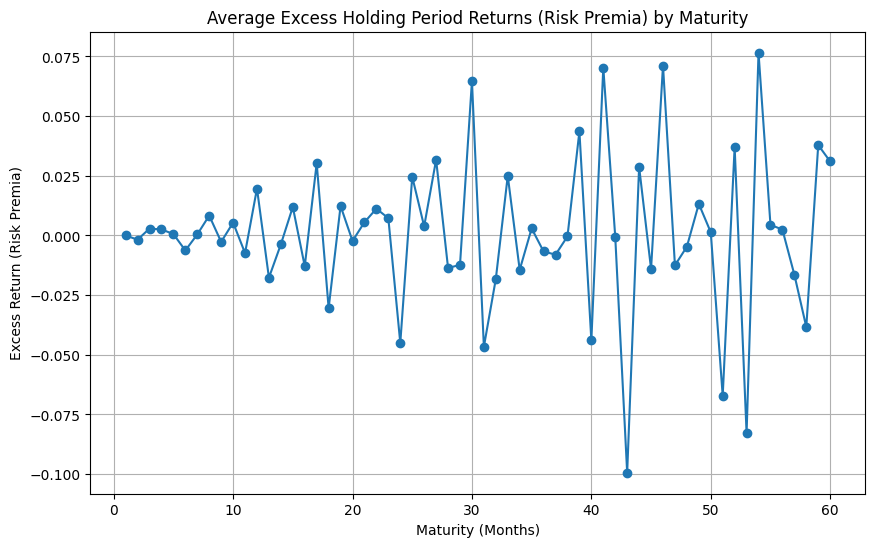

In [ ]:
#EXERCISE 6:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Setup the Data
np.random.seed(0)
dates = pd.date_range(start="2000-01-01", periods=200, freq="ME")
maturities = np.arange(1, 61)  # 1 to 60 months maturities

# Simulate model-implied yields
yields_implied = np.random.randn(200, 60) / 100
yields_implied = pd.DataFrame(yields_implied, index=dates, columns=maturities)

# Simulate risk-free rate, so we assume 1-month yield as a proxy
rf = yields_implied[1]

#Compute EH Yields
def compute_eh_yields(yields_df, maturities):
    """Compute implied EH yields based on future short rate averages."""
    eh_yields = pd.DataFrame(index=yields_df.index, columns=maturities)

    for n in maturities:
        if n == 1:
            eh_yields[n] = yields_df[1]  # By definition
        else:
            # Average of next n future short rates
            shifted = [yields_df[1].shift(-j) for j in range(n)]
            future_avg = pd.concat(shifted, axis=1).mean(axis=1)
            eh_yields[n] = future_avg

    return eh_yields

eh_yields = compute_eh_yields(yields_implied, maturities)

#Compute Expected Excess Holding Period Returns
def compute_excess_returns(yields_df, rf_series, maturities):
    """Compute expected risk premia"""
    excess_returns = pd.DataFrame(index=yields_df.index, columns=maturities)

    for n in maturities:
        if n == 1:
            excess_returns[n] = 0  # No excess return for 1-month
            continue

        # Expected change in yield (y_{n-1, t+1} - y_{n, t})
        fwd_return = yields_df[n-1].shift(-1) - yields_df[n]

        # Formula: -(n-1) * Et(change) + (y_{n,t} - rf)
        excess_returns[n] = -(n - 1) * fwd_return + (yields_df[n] - rf_series)

    return excess_returns

excess_return_premia = compute_excess_returns(yields_implied, rf, maturities)

#GRAPH THE RISK PREMIa across maturities
avg_excess_return = excess_return_premia.mean()

plt.figure(figsize=(10, 6))
plt.plot(maturities, avg_excess_return, marker='o')
plt.title("Average Excess Holding Period Returns (Risk Premia) by Maturity")
plt.xlabel("Maturity (Months)")
plt.ylabel("Excess Return (Risk Premia)")
plt.grid(True)
plt.show()


EXERCISE 6:

I placed it on a graph to aid visualization so and firstly I notice that for the short maturities, for those in the 1 year range (1- 12 months), the risk premia are small and they hover around 0. Which coincides with what we've learnt on how short-term bonds have low risk. Another thing I noted while looking at the graph is that as the maturity increases, the risk premia shows more vlatility. Which makes sense as longer-term bonds do carry more uncertainty. Looking at the graph, the pattern does become noiser from around 40-60 months, as I can see more frequent spikes that are both negative and positive.

Overall, the average trend is upward sloping as longer maturities i think get higher xpected excess returns. This works with the idea that risk premia increase with maturity essentially.